# Head curvature decoding - avg - time bin

## Set up

In [1]:
using PyCall, Statistics, StatsBase, HDF5, FlavellBase, PyPlot, ProgressMeter, AnalysisBase,
    LinearAlgebra, Distributions, MLJLinearModels, ANTSUNData, Interpolations, Lasso

WebIO._IJuliaInit()

### Functions

#### fit

In [2]:
zstd = FlavellBase.standardize
function cost_mse(y, y_pred)
    mean((y .- y_pred) .^ 2)
end

function fit_linear_L2(x::Array, y::Vector; λ=0.)
    # x: (n, n_f) n: number of examples, n_f: number of features. first column: ones
    # y: vector of n where n is number of examples
    b = (x' * x + I * λ) \ (x' * y)
    
    y_pred = x * b        

    return b, y_pred
end

function fit_linear_L2(x::Array, y::Vector, x_test::Array, y_test::Vector;
        λ=0., f_cost::Function)
    # x: (n, n_f) n: number of examples, n_f: number of features. first column: ones
    # y: vector of n where n is number of examples
    b = (x' * x + I * λ) \ (x' * y)

    y_pred = x * b        
    y_pred_test = x_test * b
    
    cost_train = f_cost(y, y_pred)
    cost_test = f_cost(y_test, y_pred_test)

    return b, y_pred, y_pred_test, cost_train, cost_test
end

function fit_linear_mlj(x::Array, y::Vector, x_test::Array, y_test::Vector; model, f_cost, solver=nothing)
    # x: (n, n_f) n: number of examples, n_f: number of features. bias is automatically added
    # y: vector of n where n is number of examples
    θ = isnothing(solver) ? MLJLinearModels.fit(model, x, y) :
        MLJLinearModels.fit(model, x, y, solver=solver)
    
    y_pred = hcat(x, ones(length(y))) * θ       
    y_pred_test = hcat(x_test, ones(length(y_test))) * θ
    
    cost_train = f_cost(y, y_pred)
    cost_test = f_cost(y_test, y_pred_test)

    return θ, y_pred, y_pred_test, cost_train, cost_test
end

function fit_linear_lasso(x::Array, y::Vector, x_test::Array, y_test::Vector;
        f_cost, lasso_α=0.5, lasso_select=MinBIC(), nλ=100)
    lasso_fit = Lasso.fit(LassoPath, x, y, α=lasso_α, nλ=nλ)

    b = coef(lasso_fit, lasso_select)
    
    y_pred = predict(lasso_fit, x, select=lasso_select)
    y_pred_test = predict(lasso_fit, x_test, select=lasso_select)
    
    cost_train = f_cost(y, y_pred)
    cost_test = f_cost(y_test, y_pred_test)
    
    b, y_pred, y_pred_test, cost_train, cost_test, lasso_fit
end

fit_linear_lasso (generic function with 1 method)

#### future

In [3]:
function get_data_future(x,y; list_idx_neuron, rg_x_Δt=0,
        Δt_pred::Int, idx_train, idx_test)
    if sort(idx_train)[end] + Δt_pred > length(y)
        error("idx_train is not compatible with Δt_pred")
    end
    if sort(idx_test)[end] + Δt_pred > length(y)
        error("idx_test is not compatible with Δt_pred")
    end
    
    y_train = y[idx_train .+ Δt_pred]
    y_test = y[idx_test .+ Δt_pred]
    x_train = ones(length(idx_train), length(list_idx_neuron) * length(rg_x_Δt) + 1)
    x_test = ones(length(idx_test), length(list_idx_neuron) * length(rg_x_Δt) + 1)
    
    n_neuron = length(list_idx_neuron)
    
    for (i,t) = enumerate(idx_train)
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 2 + (j-1) * n_neuron
            stop_ = 1 + j * n_neuron
            x_train[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end
    
    for (i,t) = enumerate(idx_test)
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 2 + (j-1) * n_neuron
            stop_ = 1 + j * n_neuron
            x_test[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end

    x_train, y_train, x_test, y_test
end

function get_data_aggergate_future(x::Array, y::Vector; list_idx_neuron, rg_x_Δt=0,
        Δt_pred::Int, n_window::Int, f_aggregate::Function, idx_train, idx_test)
    if sort(idx_train)[end] + Δt_pred > length(y)
        error("idx_train is not compatible with Δt_pred")
    end
    if sort(idx_test)[end] + Δt_pred > length(y)
        error("idx_test is not compatible with Δt_pred")
    end
    
    y_train = zeros(length(idx_train))
    y_test = zeros(length(idx_test))
    
    x_train = ones(length(idx_train), length(list_idx_neuron) * length(rg_x_Δt) + 1)
    x_test = ones(length(idx_test), length(list_idx_neuron) * length(rg_x_Δt) + 1)
    n_neuron = length(list_idx_neuron)
    
    for (i,t) = enumerate(idx_train)
        t1 = t+Δt_pred-(ceil(Int, n_window/2)-1)
        t2 = t+Δt_pred+floor(Int, n_window/2)
        y_train[i] = f_aggregate(y[t1:t2])
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 2 + (j-1) * n_neuron
            stop_ = 1 + j * n_neuron
            x_train[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end
    
    for (i,t) = enumerate(idx_test)
        t1 = t+Δt_pred-(ceil(Int, n_window/2)-1)
        t2 = t+Δt_pred+floor(Int, n_window/2)
        y_test[i] = f_aggregate(y[t1:t2])
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 2 + (j-1) * n_neuron
            stop_ = 1 + j * n_neuron
            x_test[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end

    x_train, y_train, x_test, y_test
end

function get_data_aggergate_nobias_future(x::Array, y::Vector; list_idx_neuron, rg_x_Δt=0,
        Δt_pred::Int, n_window::Int, f_aggregate::Function, idx_train, idx_test)
    if sort(idx_train)[end] + Δt_pred > length(y)
        error("idx_train is not compatible with Δt_pred")
    end
    if sort(idx_test)[end] + Δt_pred > length(y)
        error("idx_test is not compatible with Δt_pred")
    end
    
    y_train = zeros(length(idx_train))
    y_test = zeros(length(idx_test))
    
    x_train = ones(length(idx_train), length(list_idx_neuron) * length(rg_x_Δt))
    x_test = ones(length(idx_test), length(list_idx_neuron) * length(rg_x_Δt))
    n_neuron = length(list_idx_neuron)
    
    for (i,t) = enumerate(idx_train)
        t1 = t+Δt_pred-(ceil(Int, n_window/2)-1)
        t2 = t+Δt_pred+floor(Int, n_window/2)
        y_train[i] = f_aggregate(y[t1:t2])
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 1 + (j-1) * n_neuron
            stop_ = 0 + j * n_neuron
            x_train[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end
    
    for (i,t) = enumerate(idx_test)
        t1 = t+Δt_pred-(ceil(Int, n_window/2)-1)
        t2 = t+Δt_pred+floor(Int, n_window/2)
        y_test[i] = f_aggregate(y[t1:t2])
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 1 + (j-1) * n_neuron
            stop_ = 0 + j * n_neuron
            x_test[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end

    x_train, y_train, x_test, y_test
end

get_data_aggergate_nobias_future (generic function with 1 method)

#### past

In [4]:
function get_data(x::Array, y::Vector; list_idx_neuron, rg_x_Δt=0,
        Δt_pred::Int, idx_train, idx_test)
    if sort(idx_train)[1] - Δt_pred < 1
        error("idx_train is not compatible with Δt_pred")
    end
    if sort(idx_test)[1] - Δt_pred < 1
        error("idx_test is not compatible with Δt_pred")
    end
    
    y_train = y[idx_train .- Δt_pred]
    y_test = y[idx_test .- Δt_pred]
    x_train = ones(length(idx_train), length(list_idx_neuron) * length(rg_x_Δt) + 1)
    x_test = ones(length(idx_test), length(list_idx_neuron) * length(rg_x_Δt) + 1)
    n_neuron = length(list_idx_neuron)
    
    for (i,t) = enumerate(idx_train)
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 2 + (j-1) * n_neuron
            stop_ = 1 + j * n_neuron
            x_train[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end
    
    for (i,t) = enumerate(idx_test)
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 2 + (j-1) * n_neuron
            stop_ = 1 + j * n_neuron
            x_test[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end

    x_train, y_train, x_test, y_test
end

function get_data_aggergate(x::Array, y::Vector; list_idx_neuron, rg_x_Δt=0,
        Δt_pred::Int, n_window::Int, f_aggregate::Function, idx_train, idx_test)
    if sort(idx_train)[1] - Δt_pred < 1
        error("idx_train is not compatible with Δt_pred")
    end
    if sort(idx_test)[1] - Δt_pred < 1
        error("idx_test is not compatible with Δt_pred")
    end
    
    y_train = zeros(length(idx_train))
    y_test = zeros(length(idx_test))
    
    x_train = ones(length(idx_train), length(list_idx_neuron) * length(rg_x_Δt) + 1)
    x_test = ones(length(idx_test), length(list_idx_neuron) * length(rg_x_Δt) + 1)
    n_neuron = length(list_idx_neuron)
    
    for (i,t) = enumerate(idx_train)
        t1 = t-Δt_pred-(ceil(Int, n_window/2)-1)
        t2 = t-Δt_pred+floor(Int, n_window/2)
        y_train[i] = f_aggregate(y[t1:t2])
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 2 + (j-1) * n_neuron
            stop_ = 1 + j * n_neuron
            x_train[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end
    
    for (i,t) = enumerate(idx_test)
        t1 = t-Δt_pred-(ceil(Int, n_window/2)-1)
        t2 = t-Δt_pred+floor(Int, n_window/2)
        y_test[i] = f_aggregate(y[t1:t2])
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 2 + (j-1) * n_neuron
            stop_ = 1 + j * n_neuron
            x_test[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end

    x_train, y_train, x_test, y_test
end

function get_data_aggergate_nobias(x::Array, y::Vector; list_idx_neuron, rg_x_Δt=0,
        Δt_pred::Int, n_window::Int, f_aggregate::Function, idx_train, idx_test)
    if sort(idx_train)[1] - Δt_pred < 1
        error("idx_train is not compatible with Δt_pred")
    end
    if sort(idx_test)[1] - Δt_pred < 1
        error("idx_test is not compatible with Δt_pred")
    end
    
    y_train = zeros(length(idx_train))
    y_test = zeros(length(idx_test))
    
    x_train = ones(length(idx_train), length(list_idx_neuron) * length(rg_x_Δt))
    x_test = ones(length(idx_test), length(list_idx_neuron) * length(rg_x_Δt))
    n_neuron = length(list_idx_neuron)
    
    for (i,t) = enumerate(idx_train)
        t1 = t-Δt_pred-(ceil(Int, n_window/2)-1)
        t2 = t-Δt_pred+floor(Int, n_window/2)
        y_train[i] = f_aggregate(y[t1:t2])
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 1 + (j-1) * n_neuron
            stop_ = 0 + j * n_neuron
            x_train[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end
    
    for (i,t) = enumerate(idx_test)
        t1 = t-Δt_pred-(ceil(Int, n_window/2)-1)
        t2 = t-Δt_pred+floor(Int, n_window/2)
        y_test[i] = f_aggregate(y[t1:t2])
        for (j,Δt) = enumerate(rg_x_Δt)
            start_ = 1 + (j-1) * n_neuron
            stop_ = 0 + j * n_neuron
            x_test[i,start_:stop_] = x[list_idx_neuron, t+Δt]
        end
    end

    x_train, y_train, x_test, y_test
end

get_data_aggergate_nobias (generic function with 1 method)

#### misc

In [5]:
function mark_train_test(list_train, list_test; color_train="gray", color_test="gray",
        alpha_train=0.3, alpha_test=0.1)
    # train
    x_start = list_train[1]
    x_end = 0
    for idx_gap = findall(diff(list_train) .> 1)
        x_end = list_train[idx_gap]
        
        axvspan(x_start, x_end, alpha=alpha_train,
            color=color_train, linewidth=0)
        x_start = list_train[idx_gap + 1]
    end
    x_end = list_train[end]
    axvspan(x_start, x_end, alpha=alpha_train,
        color=color_train, linewidth=0)

    # test
    x_start = list_test[1]
    x_end = 0
    for idx_gap = findall(diff(list_test) .> 1)
        x_end = list_test[idx_gap]
        
        axvspan(x_start, x_end, alpha=alpha_test,
            color=color_test, linewidth=0)
        x_start = list_test[idx_gap + 1]
    end
    x_end = list_test[end]
    axvspan(x_start, x_end, alpha=alpha_test,
        color=color_test, linewidth=0)
end

function plot_discontinuous(x, y, θ_x=1; kwargs...)
    x_start = 1
    x_end = 0
    for idx_gap = findall(diff(x) .> 1)
        x_end = idx_gap
        
        x_ = x[x_start:x_end]
        y_ = y[x_start:x_end]
        plot(x_, y_; kwargs...)
        
        x_start = idx_gap + 1
    end
    x_end = length(x)
    x_ = x[x_start:x_end]
    y_ = y[x_start:x_end]
    plot(x_, y_; kwargs...)
end

plot_discontinuous (generic function with 2 methods)

### Import data

In [6]:
path_h5_enc = "/scratch/prj_kfc/2022-10-14-baseline-enc.h5"
datasets_baseline_merged = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01"]
datasets_baseline_1600 = ["2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"];
list_uid = sort(vcat(datasets_baseline_merged, datasets_baseline_1600))

list_dict_fit = h5read.(path_h5_enc, list_uid);
list_data_dict = []
for (idx_uid, data_uid) = enumerate(list_uid)
    path_data = "/scratch/prj_kfc/processed_h5/$(data_uid)-data.h5"
    data_dict = import_data(path_data)

    push!(list_data_dict, data_dict)
end

### Set up fitting and CV

In [7]:
rg_Δt_pred = 0:100
n_window = 16

16

In [8]:
list_cv = let
    k=5
    trim = 100
    gap = 100
    idx_splits=[ceil(Int, n_window/2):(800-gap-ceil(Int, n_window/2)),(801+ceil(Int, n_window/2)):(1600-gap-ceil(Int, n_window/2))]
    
    list_t_split_trim = []
    for i = 1:length(idx_splits)
        rg = idx_splits[i]
        rg = (rg[1]+trim):rg[end]
        push!(list_t_split_trim, rg)
    end
    rg_combined = union(list_t_split_trim...)
    list_cv = []
    n_data = length(rg_combined)
    n_test = floor(Int, n_data / k)
    n_train = n_data - n_test

    for i = 1:k
        start_ = (i-1) * n_test + 1
        stop_ = i * n_test
        idx_test = rg_combined[start_:stop_]
        idx_train = setdiff(rg_combined, idx_test)
        idx_train = setdiff(idx_train, idx_test[end]:(idx_test[end] + gap))
        idx_train = setdiff(idx_train, (idx_test[1] - gap):idx_test[1])
        push!(list_cv, (idx_train, idx_test))
    end
    
    list_cv
end

5-element Vector{Any}:
 ([441, 442, 443, 444, 445, 446, 447, 448, 449, 450  …  1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492], [108, 109, 110, 111, 112, 113, 114, 115, 116, 117  …  331, 332, 333, 334, 335, 336, 337, 338, 339, 340])
 ([108, 109, 110, 111, 112, 113, 114, 115, 116, 117  …  1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492], [341, 342, 343, 344, 345, 346, 347, 348, 349, 350  …  564, 565, 566, 567, 568, 569, 570, 571, 572, 573])
 ([108, 109, 110, 111, 112, 113, 114, 115, 116, 117  …  1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492], [574, 575, 576, 577, 578, 579, 580, 581, 582, 583  …  1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022])
 ([108, 109, 110, 111, 112, 113, 114, 115, 116, 117  …  1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492], [1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032  …  1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255])
 ([108, 109, 110, 111, 112, 113, 114, 115, 116, 117  …  114

[836, 233]
[736, 233]
[736, 233]
[736, 233]
[832, 233]


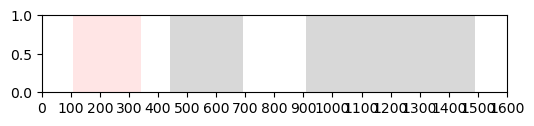

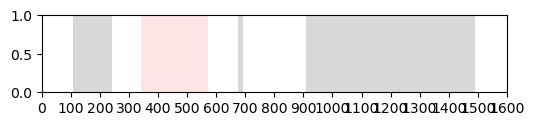

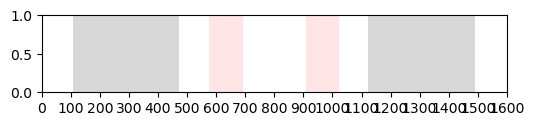

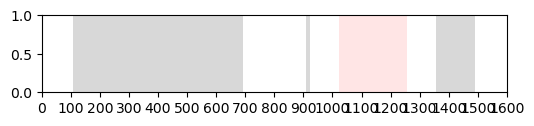

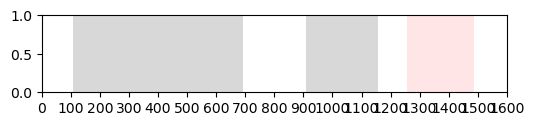

In [9]:
let
    for i = 1:length(list_cv)
        figure(figsize=(6,1))
        idx_train, idx_test = list_cv[i]
        mark_train_test(idx_train, idx_test, color_test="red")
        xlim(0,1600)
        xticks(0:100:1600)
        println(length.([idx_train, idx_test]))
    end
end

## Model fitting - hc

In [10]:
lasso_select = MinAIC()
lasso_α=0.5
# noise_11_max = 0.75
list_τ_bin = [[0,5],[5,20],[20,300]] # [t1, t2)
n_τ_bin = 2;

### control - hc

In [11]:
list_cost_control_v = zeros(2, length(list_uid), length(rg_Δt_pred), length(list_cv), 2)

@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    data_uid = list_uid[idx_uid]    
    data_dict = list_data_dict[idx_uid]

    n_neuron = data_dict["n_neuron"]
    idx_splits = data_dict["idx_splits"]
    trace_array = data_dict["trace_array"]
    n_t = size(trace_array, 2)

    trace_array = reshape(data_dict["θh"] |> zstd, (1, n_t))
    v = data_dict["θh"]

    list_idx_neuron = 1:1

    for (i_Δt, Δt_pred) = enumerate(rg_Δt_pred)
        for (i_cv, (idx_train, idx_test)) = enumerate(list_cv)
            for (i_f, f_data) = enumerate([get_data_aggergate_nobias, get_data_aggergate_nobias_future])
                x_train, y_train, x_test, y_test = f_data(trace_array, v,
                    list_idx_neuron=list_idx_neuron,
                    rg_x_Δt=0, Δt_pred=Δt_pred, idx_test=idx_test, idx_train=idx_train,
                    n_window=n_window, f_aggregate=mean)

                b, y_pred, y_pred_test, cost_train, cost_test = fit_linear_lasso(x_train, y_train,
                    x_test, y_test, f_cost=cost_mse, lasso_select=lasso_select, lasso_α=lasso_α)
                list_cost_control_v[i_f, idx_uid, i_Δt, i_cv, :] .= cost_train, cost_test
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [12]:
opt_cost_control_v = meanprj(list_cost_control_v, dims=4);

### control - hc current

In [13]:
list_cost_control_v_current = zeros(2, length(list_uid), length(rg_Δt_pred), length(list_cv), 2)

@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    data_uid = list_uid[idx_uid]    
    data_dict = list_data_dict[idx_uid]

    n_neuron = data_dict["n_neuron"]
    idx_splits = data_dict["idx_splits"]
    v = data_dict["θh"]
    n_t = length(v)
    
    v_std = zstd(v)

    trace_array = zeros(length(rg_Δt_pred)-1 + n_window, n_t)
    for (i,t) = enumerate(-n_window÷2:size(trace_array,1)-1-n_window÷2)
        trace_array[i, length(rg_Δt_pred)-1+n_window÷2:1600-n_window÷2] .= v_std[length(rg_Δt_pred)-1+n_window÷2-t:1600-n_window÷2-t]
    end
    
    list_idx_neuron = 1:size(trace_array,1)

    for (i_Δt, Δt_pred) = enumerate(rg_Δt_pred)
        for (i_cv, (idx_train, idx_test)) = enumerate(list_cv)
            for (i_f, f_data) = enumerate([get_data_aggergate_nobias, get_data_aggergate_nobias_future])
                x_train, y_train, x_test, y_test = get_data_aggergate_nobias(trace_array, v,
                    list_idx_neuron=list_idx_neuron,
                    rg_x_Δt=0, Δt_pred=Δt_pred, idx_test=idx_test, idx_train=idx_train,
                    n_window=n_window, f_aggregate=mean)

                b, y_pred, y_pred_test, cost_train, cost_test = fit_linear_lasso(x_train, y_train,
                    x_test, y_test, f_cost=cost_mse, lasso_select=lasso_select, lasso_α=lasso_α)
                list_cost_control_v_current[i_f, idx_uid, i_Δt, i_cv, :] .= cost_train, cost_test
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


In [14]:
opt_cost_control_v_current = meanprj(list_cost_control_v_current, dims=4);

### neural - all

In [15]:
list_cost_all = zeros(2, length(list_uid), length(rg_Δt_pred), length(list_cv), 2)
@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    data_uid = list_uid[idx_uid]    
    data_dict = list_data_dict[idx_uid]
    dict_fit = list_dict_fit[idx_uid]
    
    n_neuron = data_dict["n_neuron"]
    idx_splits = data_dict["idx_splits"]
    trace_array = data_dict["trace_array"]
    n_t = size(trace_array, 2)

    v = data_dict["θh"]
    
    list_idx_neuron = 1:n_neuron
    list_noise = median(list_dict_fit[idx_uid]["ps"][:,:,:,11], dims=(3,1))[:]
    list_τ = median(median(dict_fit["tau"], dims=3), dims=1)[:]
    
    list_neuron = Int[]
    for (τ_low, τ_high) = list_τ_bin
        idx_τ = findall(τ_low .<= list_τ .< τ_high)
        idx_noise_ = sortperm(list_noise[idx_τ])
        append!(list_neuron, idx_τ[idx_noise_][1:n_τ_bin])
    end
        
    list_idx_neuron = list_neuron
    
    for (i_Δt, Δt_pred) = enumerate(rg_Δt_pred)
        for (i_cv, (idx_train, idx_test)) = enumerate(list_cv)
            for (i_f, f_data) = enumerate([get_data_aggergate_nobias, get_data_aggergate_nobias_future])
                x_train, y_train, x_test, y_test = f_data(trace_array, v,
                    list_idx_neuron=list_idx_neuron,
                    rg_x_Δt=0, Δt_pred=Δt_pred, idx_test=idx_test, idx_train=idx_train,
                    n_window=n_window, f_aggregate=mean)

                b, y_pred, y_pred_test, cost_train, cost_test = fit_linear_lasso(x_train, y_train,
                    x_test, y_test, f_cost=cost_mse, lasso_select=lasso_select, lasso_α=lasso_α)
                list_cost_all[i_f, idx_uid, i_Δt, i_cv, :] .= cost_train, cost_test
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


In [16]:
opt_cost_all = meanprj(list_cost_all, dims=4);

### neural - hc

In [17]:
list_cost_v_all = zeros(2, length(list_uid), length(rg_Δt_pred), length(list_cv), 2)
@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    data_uid = list_uid[idx_uid]    
    data_dict = list_data_dict[idx_uid]
    dict_fit = list_dict_fit[idx_uid]
    n_neuron = data_dict["n_neuron"]
    idx_splits = data_dict["idx_splits"]
    trace_array = data_dict["trace_array"]
    n_t = size(trace_array, 2)

    v = data_dict["θh"]

    list_idx_v = Array{Int}[]
    for idx_rg = 1:2
        categorization = dict_fit["categorization"]["$idx_rg"]
        idx_v = categorization["θh"]["all"]
        push!(list_idx_v, idx_v)
    end    

    list_idx_neuron = intersect(list_idx_v...)

    for (i_Δt, Δt_pred) = enumerate(rg_Δt_pred)
        for (i_cv, (idx_train, idx_test)) = enumerate(list_cv)
            for (i_f, f_data) = enumerate([get_data_aggergate_nobias, get_data_aggergate_nobias_future])
                x_train, y_train, x_test, y_test = f_data(trace_array, v, list_idx_neuron=list_idx_neuron,
                    rg_x_Δt=0, Δt_pred=Δt_pred, idx_test=idx_test, idx_train=idx_train,
                    n_window=n_window, f_aggregate=mean)

                b, y_pred, y_pred_test, cost_train, cost_test = fit_linear_lasso(x_train, y_train,
                    x_test, y_test, f_cost=cost_mse, lasso_select=lasso_select, lasso_α=lasso_α)
                list_cost_v_all[i_f, idx_uid, i_Δt, i_cv, :] .= cost_train, cost_test
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


In [18]:
opt_cost_v_all = meanprj(list_cost_v_all, dims=4);

## Model fitting - shift control

In [19]:
function rand_shift_sampler(x, rg_shift; max_cor=0.2, max_attempt=1000)
    attempt = 1
    while attempt < max_attempt
        shift = rand([-1,1]) * rand(rg_shift)
        cor_shifted = cor(x, circshift(x,shift))
        if abs(cor_shifted) < max_cor
            return shift, cor_shifted, attempt
        end
        attempt += 1
    end
    
    error("could not find a shift that meets the condition. max attempt (n=$max_attempt) reached")
end

rand_shift_sampler (generic function with 1 method)

In [20]:
n_shift = 50

50

### velocity - shift

In [21]:
list_cost_shift_control_v = zeros(2, length(list_uid), length(rg_Δt_pred), length(list_cv), n_shift, 2)

@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    data_uid = list_uid[idx_uid]    
    data_dict = list_data_dict[idx_uid]

    n_neuron = data_dict["n_neuron"]
    idx_splits = data_dict["idx_splits"]
    trace_array = data_dict["trace_array"]
    n_t = size(trace_array, 2)

    trace_array = reshape(data_dict["θh"] |> zstd, (1, n_t))
    v = data_dict["θh"]

    list_idx_neuron = 1:1
 
    for i_shift = 1:n_shift
        shift, _ = rand_shift_sampler(v, 125:600)
        v_shifted = circshift(v, shift)

        for (i_Δt, Δt_pred) = enumerate(rg_Δt_pred)
            for (i_cv, (idx_train, idx_test)) = enumerate(list_cv)
                for (i_f, f_data) = enumerate([get_data_aggergate_nobias, get_data_aggergate_nobias_future])
                    x_train, y_train, x_test, y_test = f_data(trace_array, v_shifted, list_idx_neuron=list_idx_neuron,
                        rg_x_Δt=0, Δt_pred=Δt_pred, idx_test=idx_test, idx_train=idx_train,
                        n_window=n_window, f_aggregate=mean)

                    b, y_pred, y_pred_test, cost_train, cost_test = fit_linear_lasso(x_train, y_train,
                        x_test, y_test, f_cost=cost_mse, lasso_select=lasso_select, lasso_α=lasso_α)
                    list_cost_shift_control_v[i_f, idx_uid, i_Δt, i_cv, i_shift, :] .= cost_train, cost_test
                end
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:11


In [22]:
opt_cost_shift_control_v = meanprj(meanprj(list_cost_shift_control_v, dims=5), dims=4);

### velocity - current - shift

In [23]:
list_cost_shift_control_v_current = zeros(2, length(list_uid), length(rg_Δt_pred), length(list_cv), n_shift, 2)

@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    data_uid = list_uid[idx_uid]    
    data_dict = list_data_dict[idx_uid]

    n_neuron = data_dict["n_neuron"]
    idx_splits = data_dict["idx_splits"]
    v = data_dict["θh"]
    n_t = length(v)
    
    v_std = zstd(v)

    trace_array = zeros(length(rg_Δt_pred)-1 + n_window, n_t)
    for (i,t) = enumerate(-n_window÷2:size(trace_array,1)-1-n_window÷2)
        trace_array[i, length(rg_Δt_pred)-1+n_window÷2:1600-n_window÷2] .= v_std[length(rg_Δt_pred)-1+n_window÷2-t:1600-n_window÷2-t]
    end
    
    list_idx_neuron = 1:size(trace_array,1)

    for i_shift = 1:n_shift
        shift, _ = rand_shift_sampler(v, 125:600)
        v_shifted = circshift(v, shift)

        for (i_Δt, Δt_pred) = enumerate(rg_Δt_pred)
            for (i_cv, (idx_train, idx_test)) = enumerate(list_cv)
                for (i_f, f_data) = enumerate([get_data_aggergate_nobias, get_data_aggergate_nobias_future])
                    x_train, y_train, x_test, y_test = get_data_aggergate_nobias(trace_array, v_shifted,
                        list_idx_neuron=list_idx_neuron,
                        rg_x_Δt=0, Δt_pred=Δt_pred, idx_test=idx_test, idx_train=idx_train,
                        n_window=n_window, f_aggregate=mean)

                    b, y_pred, y_pred_test, cost_train, cost_test = fit_linear_lasso(x_train, y_train,
                        x_test, y_test, f_cost=cost_mse, lasso_select=lasso_select, lasso_α=lasso_α)
                    list_cost_shift_control_v_current[i_f, idx_uid, i_Δt, i_cv, i_shift, :] .= cost_train, cost_test
                end
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:39:55


In [24]:
opt_cost_shift_control_v_current = meanprj(meanprj(list_cost_shift_control_v_current, dims=5), dims=4);

### neural - all - shift

In [25]:
list_cost_shift_all = zeros(2, length(list_uid), length(rg_Δt_pred), length(list_cv), n_shift, 2)
@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    data_uid = list_uid[idx_uid]    
    data_dict = list_data_dict[idx_uid]
    dict_fit = list_dict_fit[idx_uid]
    
    n_neuron = data_dict["n_neuron"]
    idx_splits = data_dict["idx_splits"]
    trace_array = data_dict["trace_array"]
    n_t = size(trace_array, 2)

    v = data_dict["θh"]
    
    list_idx_neuron = 1:n_neuron
    list_noise = median(list_dict_fit[idx_uid]["ps"][:,:,:,11], dims=(3,1))[:]
    list_τ = median(median(dict_fit["tau"], dims=3), dims=1)[:]
    
    list_neuron = Int[]
    for (τ_low, τ_high) = list_τ_bin
        idx_τ = findall(τ_low .<= list_τ .< τ_high)
        idx_noise_ = sortperm(list_noise[idx_τ])
        append!(list_neuron, idx_τ[idx_noise_][1:n_τ_bin])
    end
        
    list_idx_neuron = list_neuron
    
    for i_shift = 1:n_shift
        shift, _ = rand_shift_sampler(v, 125:600)
        v_shifted = circshift(v, shift)

        for (i_Δt, Δt_pred) = enumerate(rg_Δt_pred)
            for (i_cv, (idx_train, idx_test)) = enumerate(list_cv)
                for (i_f, f_data) = enumerate([get_data_aggergate_nobias, get_data_aggergate_nobias_future])
                    x_train, y_train, x_test, y_test = f_data(trace_array, v_shifted, list_idx_neuron=list_idx_neuron,
                        rg_x_Δt=0, Δt_pred=Δt_pred, idx_test=idx_test, idx_train=idx_train,
                        n_window=n_window, f_aggregate=mean)

                    b, y_pred, y_pred_test, cost_train, cost_test = fit_linear_lasso(x_train, y_train,
                        x_test, y_test, f_cost=cost_mse, lasso_select=lasso_select, lasso_α=lasso_α)
                    list_cost_shift_all[i_f, idx_uid, i_Δt, i_cv, i_shift, :] .= cost_train, cost_test
                end
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:04


In [26]:
opt_cost_shift_all = meanprj(meanprj(list_cost_shift_all, dims=5), dims=4);

### neural - velocity - shift

In [27]:
list_cost_shift_v_all = zeros(2, length(list_uid), length(rg_Δt_pred), length(list_cv), n_shift, 2)
@showprogress for (idx_uid, data_uid) = enumerate(list_uid)
    data_uid = list_uid[idx_uid]    
    data_dict = list_data_dict[idx_uid]
    dict_fit = list_dict_fit[idx_uid]
    n_neuron = data_dict["n_neuron"]
    idx_splits = data_dict["idx_splits"]
    trace_array = data_dict["trace_array"]
    n_t = size(trace_array, 2)

    v = data_dict["θh"]

    list_idx_v = Array{Int}[]
    for idx_rg = 1:2
        categorization = dict_fit["categorization"]["$idx_rg"]
        idx_v = categorization["θh"]["all"]
        push!(list_idx_v, idx_v)
    end    

    list_idx_neuron = intersect(list_idx_v...)

    for i_shift = 1:n_shift
        shift, _ = rand_shift_sampler(v, 125:600)
        v_shifted = circshift(v, shift)

        for (i_Δt, Δt_pred) = enumerate(rg_Δt_pred)
            for (i_cv, (idx_train, idx_test)) = enumerate(list_cv)
                for (i_f, f_data) = enumerate([get_data_aggergate_nobias, get_data_aggergate_nobias_future])
                    x_train, y_train, x_test, y_test = f_data(trace_array, v_shifted, list_idx_neuron=list_idx_neuron,
                        rg_x_Δt=0, Δt_pred=Δt_pred, idx_test=idx_test, idx_train=idx_train,
                        n_window=n_window, f_aggregate=mean)

                    b, y_pred, y_pred_test, cost_train, cost_test = fit_linear_lasso(x_train, y_train,
                        x_test, y_test, f_cost=cost_mse, lasso_select=lasso_select, lasso_α=lasso_α)
                    list_cost_shift_v_all[i_f, idx_uid, i_Δt, i_cv, i_shift, :] .= cost_train, cost_test
                end
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:22


In [28]:
opt_cost_shift_v_all = meanprj(meanprj(list_cost_shift_v_all, dims=5), dims=4);

## Analysis

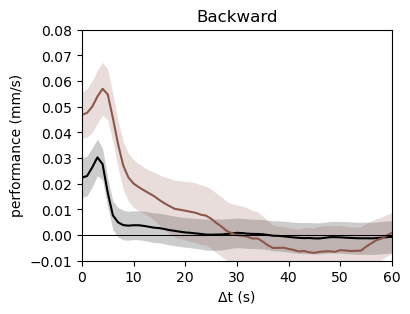

PyObject Text(0.5, 23.999999999999993, 'Δt (s)')

In [42]:
let
    rg_t = 0:60
    list_cost = [(opt_cost_control_v_current, opt_cost_shift_control_v_current, "gray"),
        (opt_cost_control_v, opt_cost_shift_control_v, "k"),
        (opt_cost_v_all, opt_cost_shift_v_all, "C5")]
    rg_idx_uid = 1:length(list_uid)
    
    figure(figsize=(4,3))
    
    for (i,(cost,cost_control,color_)) = enumerate(list_cost)
        Δcost = zeros(length(list_uid), length(rg_t))
        for (i_uid, idx_uid) = enumerate(rg_idx_uid)
            timestep = list_dict_fit[idx_uid]["timestep"]
            xs = collect(rg_Δt_pred) * timestep
            ys = sqrt.(cost_control[1,idx_uid,:,2]) .- sqrt.(cost[1,idx_uid,:,2])
            intp = LinearInterpolation(xs,ys)

            Δcost[i_uid,:] = intp.(rg_t)
        end
        u = meanprj(Δcost, dims=1)
        s = std(Δcost, dims=1)[:] / sqrt(length(rg_idx_uid)-1)
        y1 = u .- s
        y2 = u
        y3 = u .+ s
        plot(rg_t, y2, color=color_)
        fill_between(rg_t, y1, y3, color=color_, alpha=0.2, linewidth=0)
    end
    
    axhline(0, color="k", linewidth=0.75)
    ylim(-0.01, 0.08)
    yticks(-0.01:0.01:0.08)
    xlim(0,60)
    title("Backward")
    ylabel("performance (mm/s)")
    xlabel("Δt (s)")
    # legend()
    # fix_plot()

end

In [30]:
rg_Δt_pred

0:100

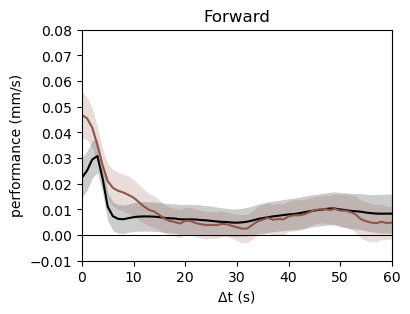

PyObject Text(0.5, 23.999999999999993, 'Δt (s)')

In [41]:
let
    rg_t = 0:60
    list_cost = [(opt_cost_control_v_current, opt_cost_shift_control_v_current, "gray"),
        (opt_cost_control_v, opt_cost_shift_control_v, "k"),
        (opt_cost_v_all, opt_cost_shift_v_all, "C5")]
    rg_idx_uid = 1:length(list_uid)
    
    figure(figsize=(4,3))
    
    for (i,(cost,cost_control,color_)) = enumerate(list_cost)
        Δcost = zeros(length(list_uid), length(rg_t))
        for (i_uid, idx_uid) = enumerate(rg_idx_uid)
            timestep = list_dict_fit[idx_uid]["timestep"]
            xs = collect(rg_Δt_pred) * timestep
            ys = sqrt.(cost_control[2,idx_uid,:,2]) .- sqrt.(cost[2,idx_uid,:,2])
            intp = LinearInterpolation(xs,ys)

            Δcost[i_uid,:] = intp.(rg_t)
        end
        u = meanprj(Δcost, dims=1)
        s = std(Δcost, dims=1)[:] / sqrt(length(rg_idx_uid)-1)
        y1 = u .- s
        y2 = u
        y3 = u .+ s
        plot(rg_t, y2, color=color_)
        fill_between(rg_t, y1, y3, color=color_, alpha=0.2, linewidth=0)
    end
    
    axhline(0, color="k", linewidth=0.75)
    ylim(-0.01, 0.05)
    yticks(-0.01:0.01:0.08)
    xlim(0,60)
    title("Forward")
    ylabel("performance (mm/s)")
    xlabel("Δt (s)")
end

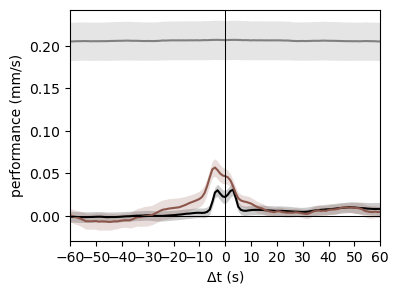

PyObject Text(0.5, 23.999999999999993, 'Δt (s)')

In [45]:
let
    rg_t = -60:60
    list_cost = [(opt_cost_control_v_current, opt_cost_shift_control_v_current, "gray"),
        (opt_cost_control_v, opt_cost_shift_control_v, "k"),
        (opt_cost_v_all, opt_cost_shift_v_all, "C5")]
    rg_idx_uid = 1:length(list_uid)
    
    figure(figsize=(4,3))
    
    for (i,(cost,cost_control,color_)) = enumerate(list_cost)
        Δcost = zeros(length(list_uid), length(rg_t))
        for (i_uid, idx_uid) = enumerate(rg_idx_uid)
            timestep = list_dict_fit[idx_uid]["timestep"]
            xs = collect(rg_Δt_pred) * timestep
            y_past_ = (sqrt.(cost_control[1,idx_uid,:,2]) .- sqrt.(cost[1,idx_uid,:,2]))
            y_past = LinearInterpolation(xs,y_past_).(0:60)
            y_future_ = sqrt.(cost_control[2,idx_uid,:,2]) .- sqrt.(cost[2,idx_uid,:,2])
            y_future = LinearInterpolation(xs,y_future_).(0:60)

            ys = vcat(reverse(y_past),y_future[2:end])
            Δcost[i_uid,:] = ys
        end
        u = meanprj(Δcost, dims=1)
        s = std(Δcost, dims=1)[:] / sqrt(length(rg_idx_uid)-1)
        y1 = u .- s
        y2 = u
        y3 = u .+ s
        plot(rg_t, y2, color=color_)
        fill_between(rg_t, y1, y3, color=color_, alpha=0.2, linewidth=0)
    end
    
    axhline(0, color="k", linewidth=0.75)
    axvline(0, color="k", linewidth=0.75)
    # ylim(-0.01, 0.05)
    # yticks(-0.01:0.01:0.08)
    xticks(-60:10:60)
    xlim(-60,60)
    ylabel("performance (mm/s)")
    xlabel("Δt (s)")
end

## Save

In [33]:
path_h5 = "/data1/prj_kfc/data/2023-04-18-decoder-time-pred-result.h5"

"/data1/prj_kfc/data/2023-04-18-decoder-time-pred-result.h5"

In [45]:
#rm(path_h5)

In [34]:
b = "hc"
h5write(path_h5, "$b/control_b_current", opt_cost_control_v_current)
h5write(path_h5, "$b/shift_control_b_current", opt_cost_shift_control_v_current)
h5write(path_h5, "$b/control_b", opt_cost_control_v)
h5write(path_h5, "$b/shift_control_b", opt_cost_shift_control_v)
h5write(path_h5, "$b/b_all", opt_cost_v_all)
h5write(path_h5, "$b/shift_b_all", opt_cost_shift_v_all)

In [38]:
h5read(path_h5, "v")

Dict{String, Any} with 6 entries:
  "shift_b_all"             => [0.000449925 0.000435597 … 0.00135656 0.00125693…
  "b_all"                   => [0.000201923 0.000204511 … 0.000417361 0.0004648…
  "control_b"               => [0.00036492 0.000359299 … 0.000572569 0.00076456…
  "shift_control_b_current" => [0.000609932 0.000684108 … 0.00191102 0.00207988…
  "shift_control_b"         => [0.000699505 0.000780948 … 0.002208 0.00219046; …
  "control_b_current"       => [8.16724e-7 7.63861e-7 … 2.02742e-6 2.29045e-6; …